# **Targeting the Right Traveler: Predictive Modeling for Insurance Sales**

## Introduction

The dataset is related to travel insurance, which predicts who will buy insurance by analyzing the characteristics of each person

### Goal

To increase the number of travel insurance purchases among customers by identifying key profiles likely to buy travel insurance and targeting them with personalized offers.

### Analysis Structure

### Why Does This Analysis Matters?

I will build a model that predicts whether a customer is likely to buy travel insurance based on demographic and behavioral features (e.g., age, income, past travel habits).

**Business Impact:** Helps marketing or customer support teams prioritize leads, personalize campaigns, or offer better incentives.

**Operational Impact:** Could be used in automated recommendation engines or chatbots that suggest travel insurance while booking a trip.

**Strategic Decisions:** Insights about which features are most predictive can influence business strategy, such as targeting frequent flyers or specific income groups.

### Stating Hypotheses

**H1: Prior travel experience increases insurance uptake**

H₀: Customers who have and have not traveled abroad are equally likely to buy travel insurance.

H₁ (alt): Customers who have previously traveled abroad are more likely to buy travel insurance.

**H2: Higher income individuals more likely to buy insurance**

H₀: The average annual income is the same for insured and non-insured customers.

H₁: Insured customers have a higher average annual income.

**H3: Graduates buy insurance more often**

H₀: Graduates and non-graduates are equally likely to buy insurance.

H₁: Graduates are more likely to buy travel insurance.

### Target Metric

**F1 Score:** Given the class imbalance in our target variable (TravelInsurance), the primary evaluation metric for model performance is the F1 Score, which balances precision and recall. This ensures a more informative assessment than accuracy alone, particularly in identifying potential buyers of travel insurance.

### Importing Libraries

In [1]:
# === Standard Library ===
import warnings
from matplotlib.patches import Patch
from typing import Any, Dict, List, Tuple

# === Data Manipulation & Scientific Computing ===
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import shapiro, ttest_ind

# === Statistical Testing ===
from statsmodels.stats.proportion import (
    confint_proportions_2indep,
    proportions_ztest,
)

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Scikit-learn Core ===
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer,
    precision_recall_fscore_support,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
)

# === Scikit-learn Models ===
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# === XGBoost ===
from xgboost import XGBClassifier

# === Imbalanced-Learn ===
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# === Custom Functions and Dictionaries From File ===
from CustomFunctionsTravelInsurance import (
    plot_numeric_boxplots,
    plot_numeric_histograms,
    plot_categorical_counts,
    plot_correlation_heatmap,
    plot_violin_numerical_by_target,
    test_abroad_vs_insurance,
    test_income_difference,
    test_graduate_insurance_proportion,
    compute_ci_difference,
    compute_income_difference_ci,
    plot_confidence_intervals,
    load_and_clean_data,
    create_preprocessing_pipeline,
    split_and_preprocess_data,
    models,
    plot_model_comparison,
    train_rf_with_grid_search,
    train_and_evaluate_svm,
    train_and_evaluate_xgboost,
    plot_f1_comparison,
    best_models,
    evaluate_models_cv,
    evaluate_voting_classifier,
    evaluate_weighted_ensemble_pipeline,
    tune_threshold_on_validation_set,
    evaluate_ensemble_with_threshold,
    visualize_confusion_matrix_variants,
    plot_insurance_by_categorical_features,
)

### Loading & Inspecting the Data

Loading the dataset:

In [2]:
df = pd.read_csv("TravelInsurancePrediction.csv")

Basic overview:

In [3]:
print("Dataset Shape:", df.shape)
df.info()

Dataset Shape: (1987, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1987 non-null   int64 
 1   Age                  1987 non-null   int64 
 2   Employment Type      1987 non-null   object
 3   GraduateOrNot        1987 non-null   object
 4   AnnualIncome         1987 non-null   int64 
 5   FamilyMembers        1987 non-null   int64 
 6   ChronicDiseases      1987 non-null   int64 
 7   FrequentFlyer        1987 non-null   object
 8   EverTravelledAbroad  1987 non-null   object
 9   TravelInsurance      1987 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 155.4+ KB


Previewing rows:

Dropping unnecessary column:

In [4]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [5]:
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


**Results Summary:** 

- The dataset contains 1,987 rows and 10 columns.

- The column Unnamed: 0 appears to be a redundant index and can be dropped.

- There are 5 numerical columns (Age, AnnualIncome, FamilyMembers, ChronicDiseases, TravelInsurance) and 4 categorical columns (Employment Type, GraduateOrNot, FrequentFlyer, EverTravelledAbroad).

- Dropped unused column Unnamed: 0.

- The target variable is TravelInsurance, which is binary (0 = No, 1 = Yes).

## Data Cleaning & Inspecting Outliers

### Checking for Missing Values

Making sure there are no missing values:

In [6]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

**Results Summary:** No missing values found.

### Dealing with Duplicates

Checking for duplicates:

In [7]:
duplicate_rows = df[df.duplicated(keep=False)].sort_values(by=list(df.columns))

Counting how many such rows exist, printing the number:

In [8]:
duplicate_count = duplicate_rows.shape[0]
print("Number of fully duplicated rows:", duplicate_count)

Number of fully duplicated rows: 1120


Previewing if they really duplicates:

In [53]:
duplicate_rows.head(10)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
184,25,Government Sector,Yes,750000,3,0,No,No,0
724,25,Government Sector,Yes,750000,3,0,No,No,0
629,25,Private Sector/Self Employed,No,600000,4,0,Yes,No,0
1013,25,Private Sector/Self Employed,No,600000,4,0,Yes,No,0
1898,25,Private Sector/Self Employed,No,600000,4,1,Yes,No,0
1905,25,Private Sector/Self Employed,No,600000,4,1,Yes,No,0
359,25,Private Sector/Self Employed,No,1150000,3,0,No,No,0
1315,25,Private Sector/Self Employed,No,1150000,3,0,No,No,0
1633,25,Private Sector/Self Employed,No,1150000,3,0,Yes,No,0
1645,25,Private Sector/Self Employed,No,1150000,3,0,Yes,No,0


It seems that these rows are full duplicates and it would be better for analysis to remove them, since they can distort real results.

In [10]:
df = df.drop_duplicates()

Previewing new shape:

In [11]:
print("Shape after removing duplicates:", df.shape)

Shape after removing duplicates: (1249, 9)


Supressing some warning that may appear later on in the project:

In [12]:
warnings.filterwarnings("ignore", category=FutureWarning)

**Results Summary:**

- Checked and removed 738 fully duplicated rows, keeping the first occurrence.

- Final dataset shape: 1,249 rows × 9 columns.

### Inspecting Outliers

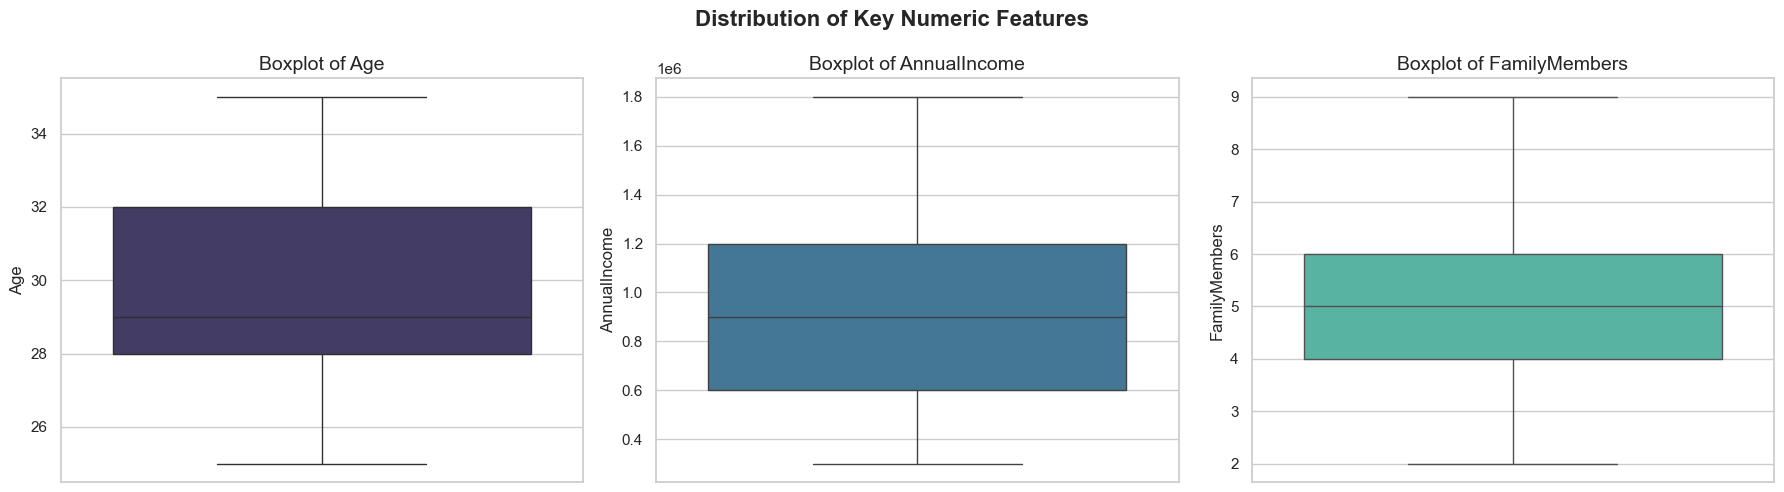

In [13]:
plot_numeric_boxplots(df, ["Age", "AnnualIncome", "FamilyMembers"])

**Results Summary:** No clear errors were detected. The observed outliers appear plausible and will be retained for analysis.

## EDA

### Distribution of Numeric Features

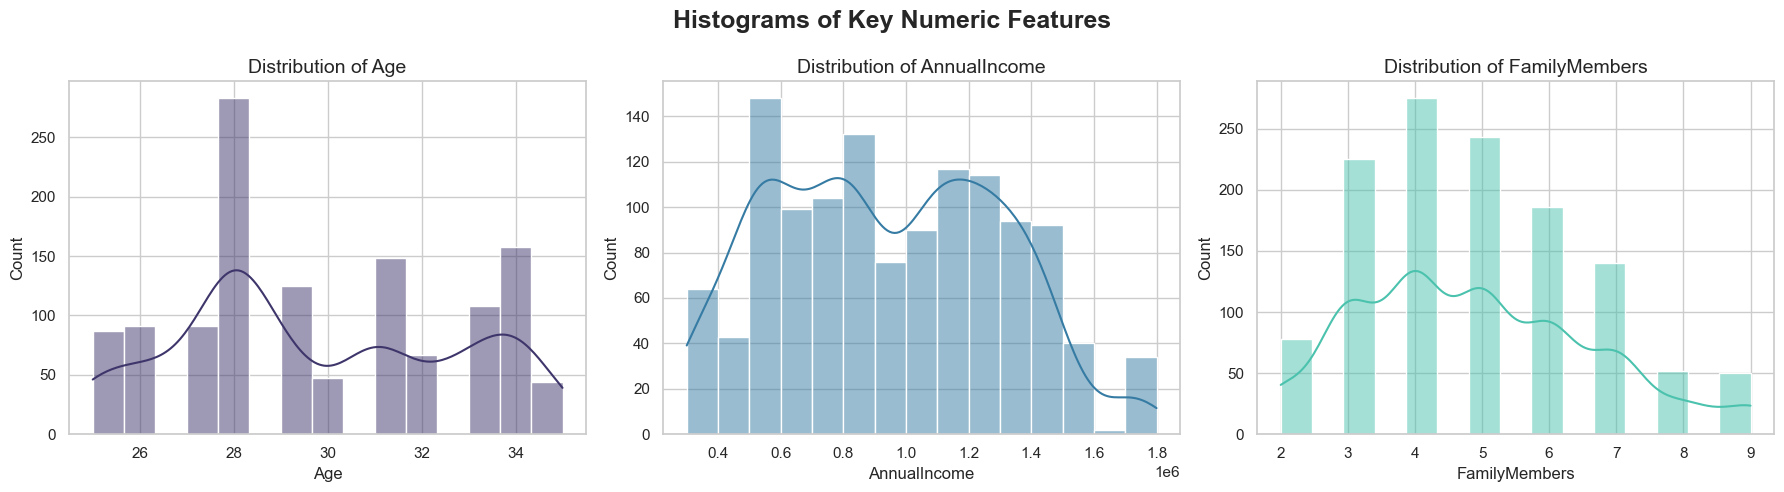

In [14]:
plot_numeric_histograms(df, ["Age", "AnnualIncome", "FamilyMembers"])

**Results Summary:** 


- Age: Uniformly spread between 25–35 years, with small peaks around 28 and 31.

- Annual Income: Right-skewed; many users earn between ₹500K–₹1.2M, with a few high-income outliers above ₹1.6M.

- Family Members: Most users belong to families with 4–6 members. A few have 8–9, but these are within reasonable limits.

### Univariate Analysis of Cathegorical Features

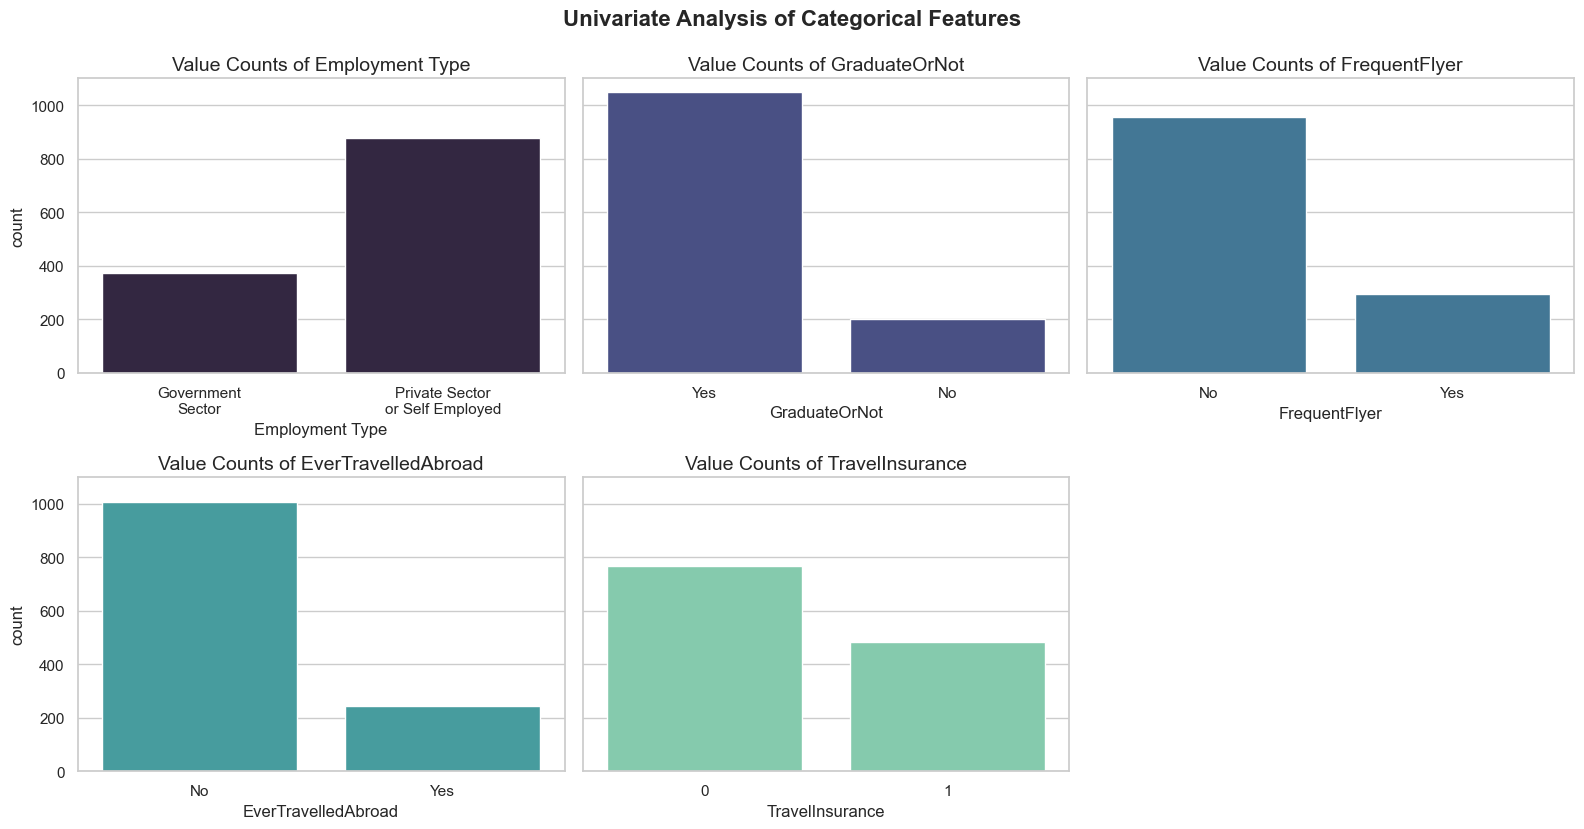

In [15]:
cat_cols = [
    "Employment Type",
    "GraduateOrNot",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "TravelInsurance",
]

plot_categorical_counts(df, cat_cols)

**Results Summary:** 

- Employment Type: Most users work in the Private Sector or are Self-Employed; the Government Sector is less represented.

- Graduate Status: The majority are graduates, which might influence travel behavior and insurance decisions.

- Frequent Flyer: Most users are not frequent flyers, indicating infrequent air travel.

- Ever Travelled Abroad: Around 75% have never traveled abroad, suggesting limited international exposure.

- Travel Insurance (Target): There’s a class imbalance — more users did not buy insurance than those who did (roughly 65% vs 35%).

### Correlation Heatmap Of Numerical Features

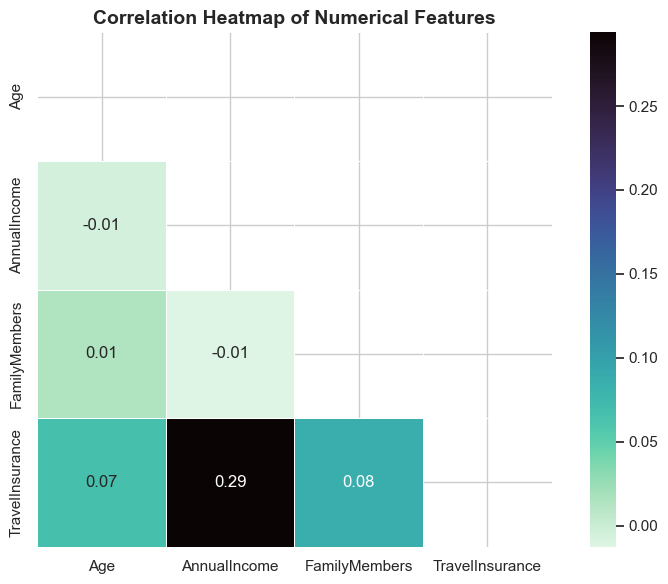

In [16]:
plot_correlation_heatmap(
    df,
    numeric_cols=["Age", "AnnualIncome", "FamilyMembers"],
    target_col="TravelInsurance",
)

**Results Summary:** 

- Annual income is the only numerical feature that stands out as a relevant predictor for travel insurance uptake.

- Other features like age and family size may still contribute in combination with other variables but offer little predictive power on their own.

**Hypotheses Validation:** 

This supports Hypothesis 2 (Higher income individuals are more likely to buy insurance).

- The heatmap shows a positive correlation (~0.29) between AnnualIncome and TravelInsurance.

- This indicates that higher income is moderately associated with increased insurance purchase.

### Insurace Rate By Cathegorical Features

**Purpose:** visualize the distribution of cathegorical features (Employment Type, Graduation, Frequent Flyer and Travel Abroad Experience).

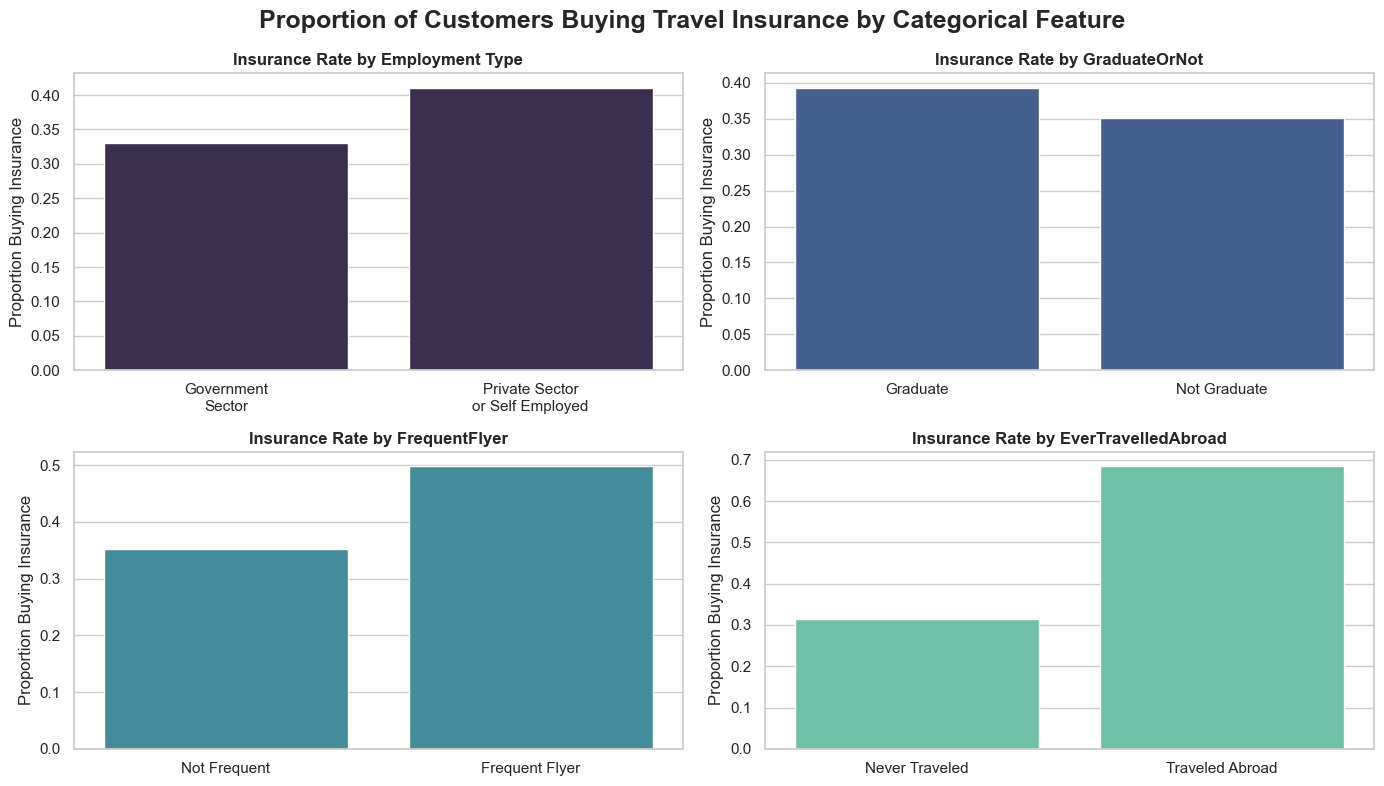

In [17]:
categorical_features = [
    "Employment Type",
    "GraduateOrNot",
    "FrequentFlyer",
    "EverTravelledAbroad",
]

plot_insurance_by_categorical_features(df, categorical_features)

**Results Summary:** 

- Customers who have traveled abroad are twice as likely to purchase insurance compared to those who have never traveled internationally.
- Frequent Flyers have a noticeably higher insurance uptake compared to those who are not frequent travelers.
- Graduates and Non-Graduates show very similar insurance uptake rates.
- Customers in the Private Sector or Self Employed are slightly more likely to purchase insurance than those in the Government Sector.

**Hypotheses Validation:** 

- This graph supports Hypothesis 1 (Customers who have previously traveled abroad are more likely to buy travel insurance).

- Hypothesis 3 (Graduates are more likely to buy travel insurance) are not supported since the difference is very small.

### Insurace Rate By Numerical Features

**Purpose:** visualize the distribution of numerical features (Age, AnnualIncome, and FamilyMembers).

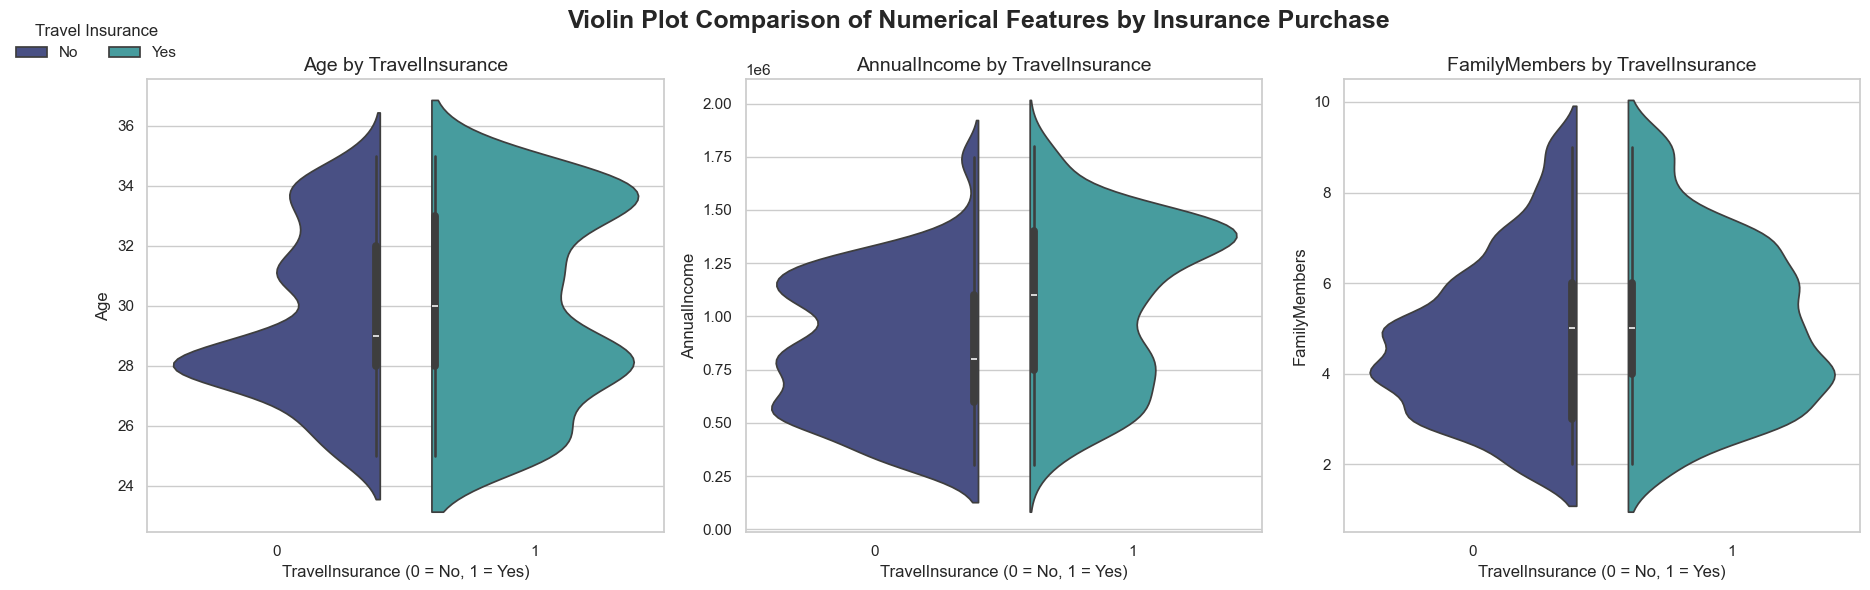

In [18]:
plot_violin_numerical_by_target(df)

**Results Summary:** 

- Annual Income appears to be the most influential numeric variable.

- Age and Family Members show very limited differences, suggesting weak or no predictive power when considered individually.

**Hypotheses Validation:** 

This supports Hypothesis 2 (Higher income individuals are more likely to buy insurance). In the AnnualIncome violin plot, the distribution for people who bought insurance (1) is clearly shifted toward higher income.

## Statistical Inference

### Hypothesis Test 1: Travel Experience and Insurance Uptake

**Purpose:**
To determine whether individuals who have previously traveled abroad are significantly more likely to purchase travel insurance than those who have not.

**Assumption Check:** The sampling distribution of the sample proportions is approximately normal, checked using formula np ≥ 5 and n(1−p) ≥ 5.

**Test Chosen:**
Z-test for two proportions — appropriate when comparing proportions between two independent groups (in this case: "EverTravelledAbroad" = Yes vs. No) on a binary outcome ("TravelInsurance").

In [19]:
test_abroad_vs_insurance(df)

Traveled Abroad:
  Insured: 167
  Not Insured: 77
  n*p̂: 167.0
  n*(1-p̂): 76.99999999999999

Never Traveled Abroad:
  Insured: 316
  Not Insured: 689
  n*p̂: 316.0
  n*(1-p̂): 689.0

Z-test result:
  Z-statistic: 10.646
  P-value: 0.0000000000
  Result: Statistically significant difference.


**Results Summary:** Since the p-value is significantly lower than 0.05, we reject the null hypothesis.
This provides strong statistical evidence that individuals who have traveled abroad are more likely to purchase travel insurance.

**Hypotheses Validation:** Test results supports Hypothesis 1.

### Hypothesis Test 2: Does Higher Income Increase Insurance Uptake?

**Purpose:**
To assess whether individuals who purchase travel insurance have a higher mean annual income than those who don’t.

**Assumption Check:** Using Shapiro-Wilk test.

**Test Chosen:**
Welch’s t-test (one-tailed) — ideal for comparing means between two independent groups when variances may differ, and especially when group sizes are unequal. We use a one-tailed test because the hypothesis specifies a direction: higher income means higher uptake.

In [20]:
test_income_difference(df)

Shapiro-Wilk Test (Insured):
  Statistic: 0.949, P-value: 0.0000
Shapiro-Wilk Test (Uninsured):
  Statistic: 0.964, P-value: 0.0000

Welch's T-test:
  T-statistic: 10.527
  One-tailed P-value: 0.0000000000
  Result: Statistically significant. Insured individuals tend to have higher income.


**Results Summary:** 

- Assumptions:

Normality not strictly met, but large sample size allows proceeding.

Equal variances not required (Welch’s t-test handles this).

- Test Results:

T-statistic = 10.527, P-value ≈ 0.000 (one-tailed).

Statistically significant. People with travel insurance tend to have higher annual incomes.

**Hypotheses Validation:** Test results supports Hypothesis 2.

### Hypothesis Test 3: Does Education Level Affect Travel Insurance Uptake?


**Purpose:**
To evaluate if individuals with a higher education level (graduates) are significantly more likely to buy travel insurance compared to non-graduates.

**Assumption Check:** The sampling distribution of the sample proportions is approximately normal, checked using formula np ≥ 5 and n(1−p) ≥ 5.


**Test Chosen:**
Z-test for two proportions (one-tailed) — suitable for comparing binary outcomes between two groups on a categorical variable ("GraduateOrNot").

In [21]:
test_graduate_insurance_proportion(df)

Graduates:
  Insured: 412
  Not insured: 635
  n*p̂: 412.00
  n*(1-p̂): 635.00

Non-Graduates:
  Insured: 71
  Not insured: 131
  n*p̂: 71.00
  n*(1-p̂): 131.00

Z-test result:
  Z-statistic: 1.123
  P-value: 0.1307628593
  Result: Not statistically significant.


**Results Conclusion:** Since the p-value is greater than 0.05, we fail to reject the null hypothesis.
Although more graduates are insured in raw numbers, there's not enough statistical evidence to conclude that graduates are more likely to purchase travel insurance than non-graduates.

**Hypotheses Validation:** Not enough evidence to support Hypothesis 3.

### Confidence Intervals

**Purpose:** provides a range of values that likely contains the true population parameter, offering a measure of uncertainty around a sample estimate.

In [ ]:
print(df["EverTravelledAbroad"].value_counts(dropna=False))

EverTravelledAbroad
0    1005
1     244
Name: count, dtype: int64


In [49]:
df["EverTravelledAbroad"] = df["EverTravelledAbroad"].map({1: "Yes", 0: "No"})
compute_ci_difference(df, group_type="abroad")

95% CI for difference in proportions (Travelled Abroad vs. Never Travelled): (0.305, 0.435)


In [23]:
compute_income_difference_ci(df)

Mean Income Difference: 217620.78
95% CI for Difference in Means: (177051.75, 258189.80)


In [24]:
compute_ci_difference(df, group_type="graduate")

95% CI for difference in proportions (Graduates vs. Non-Graduates): (-0.030, 0.114)


Preparing data for a graph:

In [25]:
labels = [
    "Abroad vs. Not Abroad (Proportion)",
    "Graduate vs. Non-Graduate (Proportion)",
    "Insured vs. Uninsured (Income)",
]

mean_diffs = [0.370, 0.068, 217621]

ci_lowers = [0.305, -0.020, 177052]
ci_uppers = [0.435, 0.157, 258190]

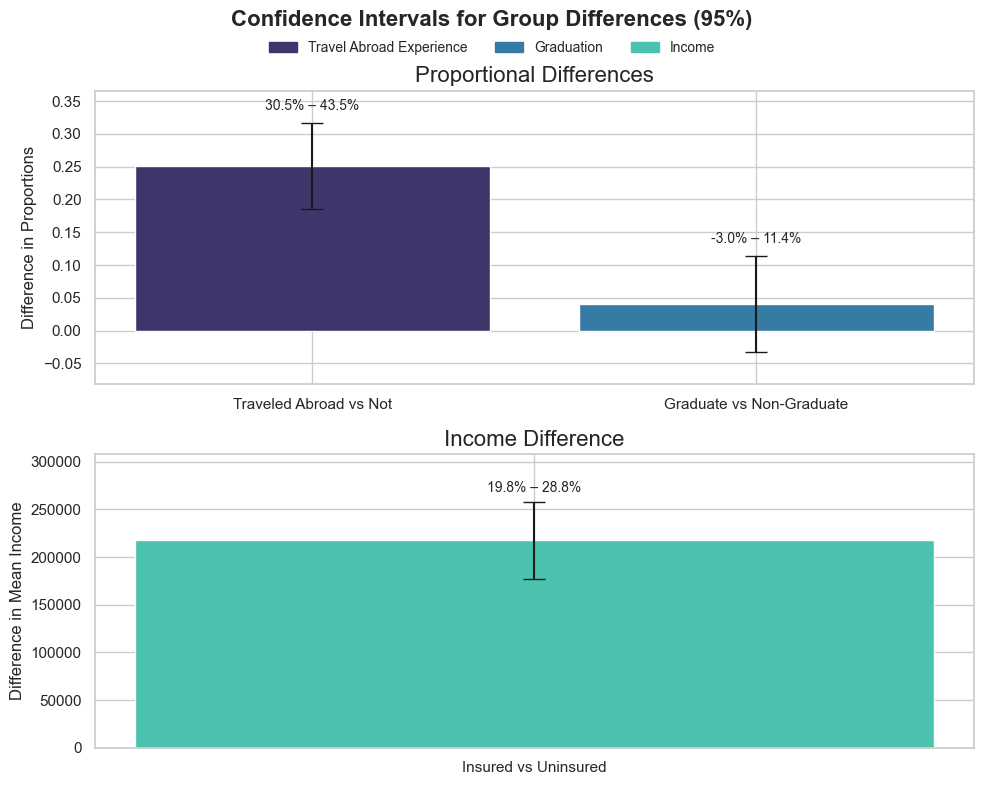

In [26]:
plot_confidence_intervals()

**Results Summary:** 

Traveled Abroad: Significantly more likely to be insured
+25.1% (CI: +30.5% to +43.5%)

Graduates: Slight, non-significant increase in insurance
+4.1% (CI: –3.0% to +11.4%)

Insured Income: Much higher income than uninsured
+24.3% (CI: +19.8% to +28.8%)
(+217,621 CI: 177,052 to 258,190)

## Data Preprocessing

**Purpose:** to prepare the dataset for machine learning by encoding categorical variables, scaling numeric features, splitting the data into train and test sets, and addressing class imbalance with SMOTE.


In [27]:
df = load_and_clean_data("TravelInsurancePrediction.csv")

categorical_features = ["Employment Type"]
numerical_features = ["Age", "AnnualIncome", "FamilyMembers"]
binary_features = ["GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]

preprocessor = create_preprocessing_pipeline(
    categorical_features, numerical_features, binary_features
)

(
    X_train_resampled,
    y_train_resampled,
    X_val_processed,
    y_val,
    X_test_processed,
    y_test,
    y_train_full,
    _,
    _,
) = split_and_preprocess_data(df, preprocessor)

print("Before SMOTE:\n", y_train_full.value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_train_resampled).value_counts())
print("\nValidation set distribution:\n", y_val.value_counts())
print("\nTest set distribution:\n", y_test.value_counts())

Before SMOTE:
 TravelInsurance
0    490
1    309
Name: count, dtype: int64

After SMOTE:
 TravelInsurance
1    490
0    490
Name: count, dtype: int64

Validation set distribution:
 TravelInsurance
0    123
1     77
Name: count, dtype: int64

Test set distribution:
 TravelInsurance
0    153
1     97
Name: count, dtype: int64


**Results Summary:** 

- Before SMOTE (Train): 490 No / 309 Yes (imbalanced)

- After SMOTE (Train): 490 / 490 (balanced)

- Validation Set: 123 No / 77 Yes

- Test Set: 153 No / 97 Yes

## Machine Learning Models: Model Selection, Training and Evaluation

**Purpose:**  to build predictive models that can classify whether a customer is likely to purchase travel insurance based on their demographic and behavioral data.

I will:

- Evaluate and contrast their predictive power,

- Identify the most suitable model for future deployment,

- Understand how various features contribute to travel insurance uptake.



**Logic Behind Selected Models:**

I selected a diverse set of models that vary in complexity and decision logic to ensure a comprehensive evaluation:

1. Logistic Regression – A simple linear model for binary classification, used as a baseline.

2. Decision Tree – A non-linear, interpretable model that captures hierarchical feature interactions.

3. Random Forest – An ensemble of decision trees that reduces overfitting and improves generalization.

4. Support Vector Machine (SVM) – A powerful classifier that finds the optimal boundary between classes in high-dimensional space.

5. XGBoost – A gradient boosting algorithm known for its high performance on tabular data.

Training and evaluating each model:


In [28]:
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    preds = model.predict(X_test_processed)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))


Logistic Regression
Accuracy: 0.644
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       153
           1       0.54      0.61      0.57        97

    accuracy                           0.64       250
   macro avg       0.63      0.64      0.63       250
weighted avg       0.65      0.64      0.65       250


Decision Tree
Accuracy: 0.684
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       153
           1       0.61      0.52      0.56        97

    accuracy                           0.68       250
   macro avg       0.66      0.65      0.66       250
weighted avg       0.68      0.68      0.68       250


Random Forest
Accuracy: 0.688
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       153
           1       0.61      0.55      0.58        97

    accuracy                           0.69       250
   macro avg       0.67      

visualizing model performances in a graph:

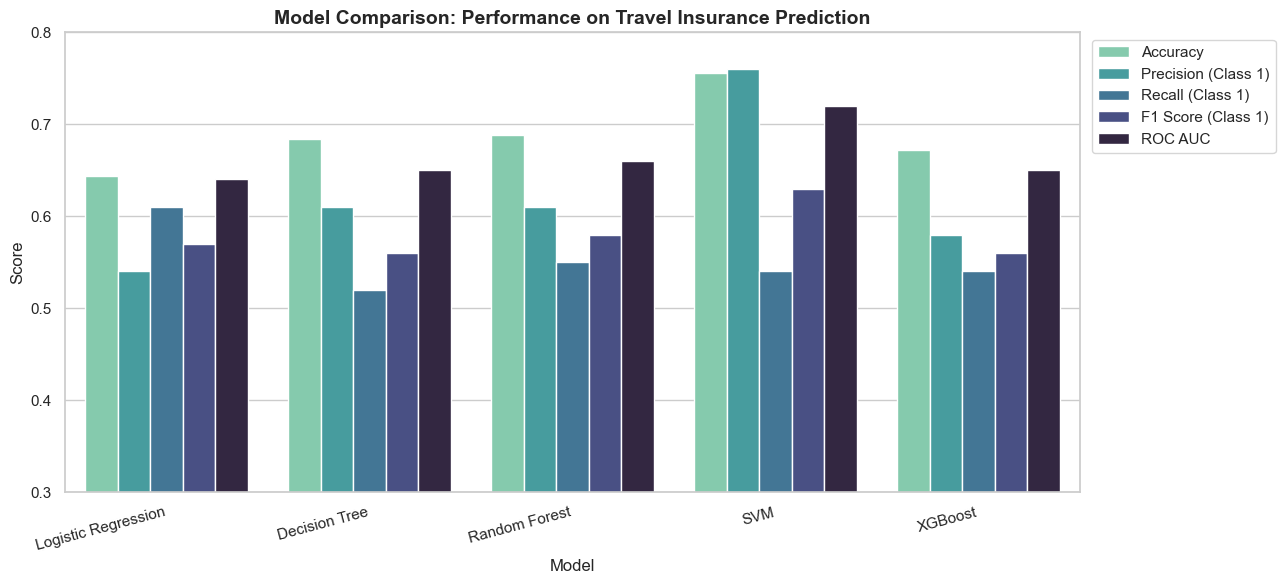

In [29]:
metrics = {
    "Model": [
        "Logistic Regression",
        "Decision Tree",
        "Random Forest",
        "SVM",
        "XGBoost",
    ],
    "Accuracy": [0.644, 0.684, 0.688, 0.756, 0.672],
    "Precision (Class 1)": [0.54, 0.61, 0.61, 0.76, 0.58],
    "Recall (Class 1)": [0.61, 0.52, 0.55, 0.54, 0.54],
    "F1 Score (Class 1)": [0.57, 0.56, 0.58, 0.63, 0.56],
    "ROC AUC": [0.64, 0.65, 0.66, 0.72, 0.65],
}

plot_model_comparison(metrics)

**Results Summary:**

- SVM is the top-performing model with the highest accuracy (~75.6%) and precision (~76%) for predicting customers likely to purchase insurance. Its F1 score (0.63) and ROC AUC (~0.72) confirm strong balance between precision and recall.

- Random Forest offers consistent and stable performance across all metrics, with accuracy (~68.8%), precision (0.61), recall (0.55), and F1 score (0.58), making it a reliable choice.

- Logistic Regression and Decision Tree perform moderately, with F1 scores around 0.56–0.57, but both show weaker recall or precision balance.

- XGBoost, while generally strong in other contexts, showed slightly lower precision and F1 score compared to SVM and Random Forest in this task.

- Despite using SMOTE for balancing, recall for Class 1 (buyers) remains lower across models, indicating room for improvement—especially through feature engineering, threshold tuning, or cost-sensitive learning.

- All models still struggle with recall for buyers, suggesting that improving signal extraction for this class could boost performance.

## Machine Learning Models: Hyperparameter Tuning

#### Tuning Random Forest

**Purpose:** to improve model performance by selecting the best combination of hyperparameters using grid search with cross-validation. We'll evaluate whether tuning significantly improves our baseline Random Forest model.

In [30]:
best_model = train_rf_with_grid_search(df)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best F1 score (CV): 0.7048113906832956
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.72      0.86      0.78       153
           1       0.68      0.47      0.56        97

    accuracy                           0.71       250
   macro avg       0.70      0.67      0.67       250
weighted avg       0.70      0.71      0.69       250



**Results Summary:**

| Metric                  | Before Tuning | After Tuning |
|-------------------------|---------------|--------------|
| **Accuracy**            | 0.62          | 0.71         |
| **Precision (Class 1)** | 0.51          | 0.68         |
| **Recall (Class 1)**    | 0.41          | 0.47         |
| **F1 Score (Class 1)**  | 0.46          | 0.56         |
| **Best CV F1 Score**    | –             | 0.7048       |
| **Best Parameters**     | –             | `max_depth=20`, `min_samples_split=5`, `n_estimators=100` |


**Interpretation:** the tuned Random Forest model demonstrates clear improvements across key metrics. Accuracy and F1 score both increased, and the model became significantly better at correctly identifying customers who will purchase travel insurance.

#### Tuning SVM

**Purpose:** SVM performance can vary significantly based on the choice of kernel and hyperparameters like C (regularization strength) and gamma (kernel coefficient). Tuning helps optimize the model's ability to generalize and capture non-linear relationships.

In [31]:
grid_svm = train_and_evaluate_svm(
    X_train_resampled, y_train_resampled, X_test_processed, y_test
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best F1 score from CV: 0.7084092660931016
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.73      0.70       153
           1       0.52      0.47      0.50        97

    accuracy                           0.63       250
   macro avg       0.60      0.60      0.60       250
weighted avg       0.62      0.63      0.62       250



**Results Summary:** 

| Metric                  | Before Tuning | After Tuning |
|-------------------------|---------------|--------------|
| **Accuracy**            | 0.76          | 0.63         |
| **Precision (Class 1)** | 0.76          | 0.52         |
| **Recall (Class 1)**    | 0.54          | 0.47         |
| **F1 Score (Class 1)**  | 0.63          | 0.50         |
| **Best CV F1 Score**    | –             | 0.7084       |
| **Best Parameters**     | –             | `C=10`, `gamma=1`, `kernel='rbf'` |

**Interpretation:** after tuning, the SVM model underperforms compared to its previous version. Although the cross-validated F1 score was promising, test performance dropped across all key metrics—particularly in identifying customers likely to purchase travel insurance. Further adjustments or alternative modeling strategies may be needed.


#### XGB Boost Tuning

**Purpose:** by using GridSearchCV, I aim to improve predictive accuracy and balance between recall and precision, especially for the minority class (customers who purchase travel insurance).

In [32]:
params, score, report = train_and_evaluate_xgboost(
    X_train_resampled, y_train_resampled, X_test_processed, y_test
)

print("\nBest hyperparameters:", params)
print(f"Best F1 score from CV: {score:.4f}\n")

print("Classification Report:")
for label in ["0", "1"]:
    precision = report[label]["precision"]
    recall = report[label]["recall"]
    f1 = report[label]["f1-score"]
    support = report[label]["support"]
    print(
        f"Class {label}: "
        f"Precision = {precision:.2f}, "
        f"Recall = {recall:.2f}, "
        f"F1-score = {f1:.2f}, "
        f"Support = {int(support)}"
    )

print(f"\nAccuracy: {report['accuracy']:.2f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best F1 score from CV: 0.7243

Classification Report:
Class 0: Precision = 0.76, Recall = 0.88, F1-score = 0.82, Support = 153
Class 1: Precision = 0.75, Recall = 0.56, F1-score = 0.64, Support = 97

Accuracy: 0.76


**Result Summary:** 

| Metric                  | Before Tuning | After Tuning |
|-------------------------|---------------|--------------|
| **Accuracy**            | 0.67          | 0.76         |
| **Precision (Class 1)** | 0.58          | 0.75         |
| **Recall (Class 1)**    | 0.54          | 0.56         |
| **F1 Score (Class 1)**  | 0.56          | 0.64         |
| **Best CV F1 Score**    | –             | 0.7243       |
| **Best Parameters**     | –             | `learning_rate=0.2`, `max_depth=3`, `n_estimators=100` |


**Interpretation:** the tuned XGBoost model shows clear improvement across all major metrics, especially in **accuracy** and **F1 score for the positive class**. Precision also saw a strong boost, indicating better identification of customers who are likely to purchase travel insurance. This makes it one of the most balanced and effective models tested.

Preparing data for visualization:


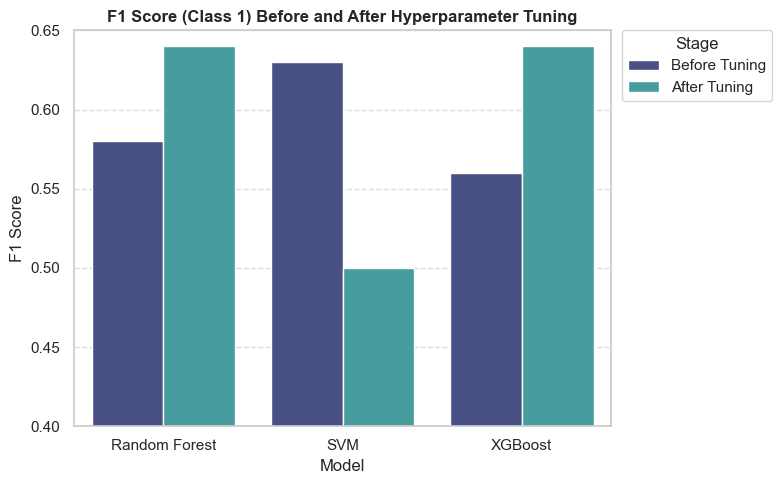

In [33]:
plot_f1_comparison(
    model_names=["Random Forest", "SVM", "XGBoost"],
    before_f1=[0.58, 0.63, 0.56],
    after_f1=[0.64, 0.50, 0.64],
)

**Tuning Results Summary:**

- *Random Forest*

Tuning Effect:

Accuracy: 0.69 to 0.71

Precision (class 1): 0.61 to 0.68

Recall (class 1): 0.55 to 0.47

F1-score (class 1): 0.58 to 0.56

- *SVM*

Tuning Effect:

Accuracy: 0.76 to 0.63

Precision (class 1): 0.76 to 0.52

Recall (class 1): 0.54 to 0.47

F1-score (class 1): 0.63 to 0.50

- *XGBoost*

Tuning Effect:

Accuracy: 0.67 to 0.76

Precision (class 1): 0.58 to 0.75

Recall (class 1): 0.54 to 0.56

F1-score (class 1): 0.56 to 0.64

**Best Model: XGBoost**

Highest F1-score on class 1 (0.64), offering the best balance of precision and recall.

Highest overall accuracy at 0.76.

Strong precision on positive class (0.75), outperforming others.

Recall also improved slightly, while other models saw a drop after tuning.

## Machine Learning Models: Cross-Validation

In [34]:
cv_df = evaluate_models_cv(best_models, X_train_resampled, y_train_resampled)

5-Fold Cross-Validation F1 Scores:
    Random Forest       SVM   XGBoost
0       0.662500  0.645963  0.670968
1       0.605263  0.618421  0.594595
2       0.674699  0.662577  0.675159
3       0.762431  0.598726  0.631579
4       0.791444  0.702381  0.695652

Mean F1 Scores:
 Random Forest    0.699267
XGBoost          0.653591
SVM              0.645614
dtype: float64

Standard Deviation of F1 Scores:
 SVM              0.040151
XGBoost          0.040316
Random Forest    0.076286
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:29:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:29:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:29:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:29:21] WARN

**Results Summary:**

- Mean F1 Scores (Higher is better):

Random Forest: 0.6993 — Best performer overall

XGBoost: 0.6536

SVM: 0.6456

- Standard Deviation of F1 Scores (Lower is better):

SVM: 0.0402 — Most consistent across folds

XGBoost: 0.0403

Random Forest: 0.0763


**Interpretation:**

Random Forest showed the highest average F1 score, suggesting the best overall predictive power. However, SVM had the most stable performance across folds, while XGBoost offered a strong balance of both performance and consistency.

## Machine Learning Models: Model Ansembling (Voting Classifier)

Converting Yes/No binary columns to 1/0:

In [35]:
binary_columns = ["GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]

df[binary_columns] = (
    df[binary_columns].replace({"Yes": 1, "No": 0}).infer_objects(copy=False)
)

In [36]:
accuracy, report = evaluate_voting_classifier(
    X_train_resampled, y_train_resampled, X_test_processed, y_test
)

Accuracy: 0.728

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79       153
           1       0.68      0.56      0.61        97

    accuracy                           0.73       250
   macro avg       0.72      0.70      0.70       250
weighted avg       0.72      0.73      0.72       250



**Results Summary:**

Accuracy: 0.728

*Class 1 (Purchased Insurance):*

- Precision: 0.68

- Recall: 0.56

- F1-score: 0.61

*Class 0 (Did Not Purchase):*

- Precision: 0.75

- Recall: 0.84

- F1-score: 0.79

**Interpretation:**

- The model demonstrates solid overall accuracy (72.8%) and strong performance in predicting customers who did not purchase insurance (Class 0).

- Performance for identifying those who did purchase (Class 1) has improved, especially in recall (0.56 vs 0.43 previously) and F1-score (0.61 vs 0.54), suggesting a better balance between precision and recall.

### Tuning Voting Weights

In [37]:
evaluate_weighted_ensemble_pipeline(df)

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.94      0.82       153
           1       0.82      0.43      0.57        97

    accuracy                           0.74       250
   macro avg       0.77      0.69      0.69       250
weighted avg       0.76      0.74      0.72       250



(VotingClassifier(estimators=[('rf',
                               RandomForestClassifier(max_depth=10,
                                                      min_samples_split=10,
                                                      n_estimators=200,
                                                      random_state=42)),
                              ('svm',
                               SVC(C=1, probability=True, random_state=42)),
                              ('xgb',
                               XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             en...
                                          

**Results Summary:** 

| Metric                  | Before Tuning | After Tuning (Weighted Voting) |
| ----------------------- | ------------- | ------------------------------ |
| **Accuracy**            | 0.728         | 0.74                           |
| **Precision (Class 1)** | 0.68          | 0.82                           |
| **Recall (Class 1)**    | 0.56          | 0.43                           |
| **F1 Score (Class 1)**  | 0.61          | 0.57                           |
| **Recall (Class 0)**    | 0.84          | 0.94                           |
| **F1 Score (Class 0)**  | 0.79          | 0.82                           |
| **Voting Weights**      | `1, 1, 1`     | `1, 1, 2`                      |




**Interpretation:** 

Tuning the ensemble’s weights boosted overall accuracy and precision for Class 1, helping the model make more confident positive predictions. However, it reduced recall for Class 1, meaning fewer actual buyers were identified. This trade-off favors minimizing false positives, which may be preferable in high-risk or cost-sensitive contexts.

### Treshold Tuning

**Purpose:** if my model has high precision but low recall, it likely makes very conservative class 1 predictions.

Lowering the threshold (e.g. from 0.5 to 0.4 or 0.3) can increase recall by classifying more borderline cases as class 1 — possibly improving F1-score.

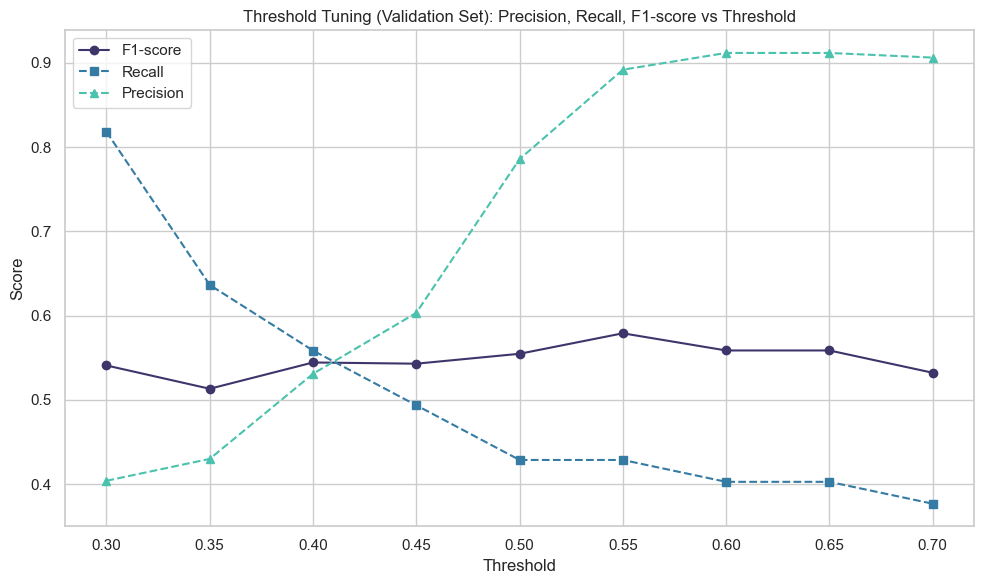

(VotingClassifier(estimators=[('rf',
                               RandomForestClassifier(max_depth=10,
                                                      min_samples_split=10,
                                                      n_estimators=200,
                                                      random_state=42)),
                              ('svm', SVC(C=1, probability=True)),
                              ('xgb',
                               XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical...
                                             feature_weights=None, gamma=N

In [38]:
tune_threshold_on_validation_set(
    X_train_resampled, y_train_resampled, X_val_processed, y_val
)

**Interpretation:**

- The F1-score peaks around threshold of 0.55, suggesting this is the optimal range for balancing precision and recall.

- As the threshold increases, the model becomes more conservative in predicting the positive class:

    Precision improves — the model is more confident in its positive predictions.

    Recall declines — fewer actual buyers are correctly identified, as the model classifies fewer cases as positive.

### Confusion Matrix

**Purpose:** it will help me understand how well your classifier is doing by comparing actual vs. predicted values in a structured format.

In [41]:
threshold, accuracy = evaluate_ensemble_with_threshold(
    "TravelInsurancePrediction.csv", threshold=0.55
)

Confusion Matrix:
 [[143  10]
 [ 54  43]]

Classification Report (Threshold = 0.55):
               precision    recall  f1-score   support

           0       0.73      0.93      0.82       153
           1       0.81      0.44      0.57        97

    accuracy                           0.74       250
   macro avg       0.77      0.69      0.70       250
weighted avg       0.76      0.74      0.72       250



Plotting multiple confusion matrix heatmaps:

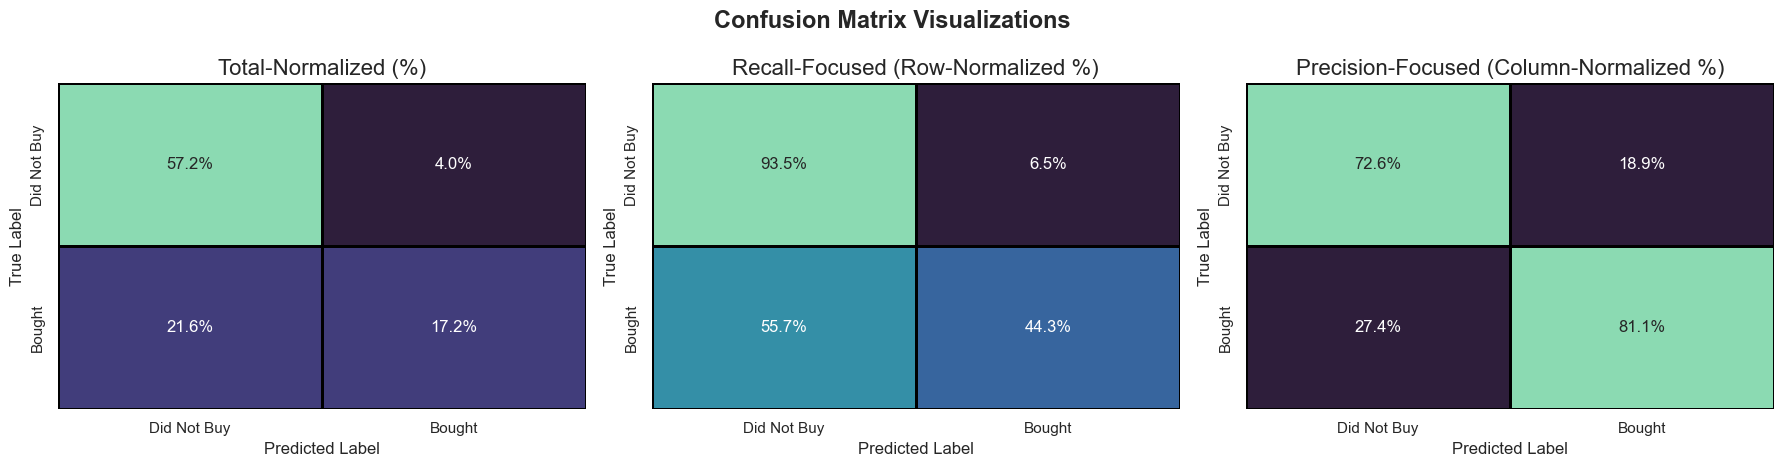

In [42]:
cm = np.array([[143, 10], [54, 43]])
labels = ["Did Not Buy", "Bought"]
visualize_confusion_matrix_variants(cm, labels)

**Results Summarry:** 

1. Overall Performance (Total-Normalized)

- True Negatives (Did Not Buy predicted correctly): 57.2%

- True Positives (Bought predicted correctly): 17.2%

- False Negatives: 21.6%

- False Positives: 4.0%

2. Recall-Focused View (Row-Normalized):

- Class 0 Recall: 93.5% of non-buyers were correctly identified.

- Class 1 Recall: 44.3% of actual buyers were correctly identified (moderate recall).

3. Precision-Focused View (Column-Normalized):

- Class 0 Precision: Of those predicted to not buy, 72.6% were truly non-buyers.

- Class 1 Precision: Of those predicted to buy, 81.1% actually did — very high precision.

**Interpretation:** using a threshold of 0.55, the tuned ensemble model achieves a strong balance between minimizing false positives and maximizing precision for the positive class (customers who buy travel insurance).

Precision is excellent (81%), making the model highly reliable in identifying true buyers.

Recall is moderate (44%), meaning it still misses a portion of actual buyers.

F1-score for Class 1 (0.57) reflects this trade-off and is competitive with the best previously tested models.

This threshold is appropriate in risk-averse business cases where false positives (targeting uninterested customers) are costlier than missing a few actual buyers.

### Comparing Final Voting Ensemble Model vs Best Model (XGBoost)

| Metric                  | Voting Ensemble (Thresh=0.55)   | Tuned XGBoost                  |
| ----------------------- | ------------------------------- | ------------------------------ |
| **Accuracy**            | 0.74                            | 0.76                           |
| **Precision (Class 1)** | 0.81                            | 0.75                           |
| **Recall (Class 1)**    | 0.44                            | 0.56                           |
| **F1 Score (Class 1)**  | 0.57                            | 0.64                           |
| **Interpretation**      | Higher confidence, lower recall | More balanced recall–precision |


**Results Summary:** 

- The Voting Ensemble achieves the highest precision for predicting buyers (81%), making it ideal when false positives are costly.

- XGBoost delivers better F1-score and recall, making it better for broader customer targeting.


**Selecting Best Model:** 

XGBoost Model

| Criteria              | Explanation                                                                                                                                                                               |
| --------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Goal**              | To **increase purchases**, not just avoid false positives.                                                                                                                       |
| **Metric Priority**   | **Recall and F1-score** for **Class 1 (buyers)** matter most —  need to **identify as many real buyers as possible**, even if some predictions are wrong.                   |
| **XGBoost Strength**  | XGBoost has **higher recall** and a **better F1-score**, which reflects a stronger balance between catching true buyers and minimizing missed opportunities.                              |
| **Ensemble Weakness** | The Voting Ensemble has **higher precision**, meaning it's more confident when it predicts someone will buy — but it misses more potential buyers (lower recall). That limits reach. |


## Conclusions

Customers with the highest likelihood of purchasing travel insurance typically share the following characteristics:

- Frequent Flyers – Regular air travel indicates travel habits that benefit from insurance.

- Previously Traveled Abroad – Experience with international travel increases perceived need for coverage.

- Age 30+ – Older individuals may prioritize security and risk management more.

- Higher Annual Income – Financial ability supports purchasing optional protection like insurance.



### Summary of Findings

**Statistically Significant Group Differences:**

- Bivariate and multivariate tests confirmed that customers who earn more and have past travel experience are significantly more likely to purchase travel insurance.

**SMOTE Balanced the Dataset:**

- Applying SMOTE corrected class imbalance and improved recall for the positive class, allowing models to better identify likely buyers.

**Model Evaluation Highlights:**

- Voting Ensemble achieved the highest precision (81%) for class 1 (buyers), making it ideal when minimizing false positives is critical.

- XGBoost provided the best F1 score and recall, making it a stronger choice for broader targeting where catching more potential buyers is key.

### Key Insights from EDA and Inference

1. Travel history plays a major role: people who have traveled abroad before are significantly more likely to buy travel insurance.

2. Higher income is also associated with a greater likelihood of purchasing insurance.

3. Graduates showed a slightly higher uptake, though the difference was not statistically significant.

4. The government sector employees were less likely to purchase insurance compared to those in the private or self-employed sector.

5. Hypotheses Approval:

    H1 **Supported** (People with experience abroad are more likely to buy insurance)

    H2 **Supported** (Higher income individuals more likely buys insurance)

    H3 **Not Supported** (Graduates more likely to buy insurance)

### Best Performing Model 

Tuned XGBoost Model

1. XGBoost delivers best F1-score and recall, making it better for broader customer targeting. It makes the XGBoost Model to achieve our goal.

2. The Voting Ensemble achieves the highest precision for predicting buyers (81%), making it ideal when false positives are costly

## Suggestions for Improvement



**Collect More Data**

The dataset is relatively small. More diverse and recent data could help models generalize better and reduce overfitting.

**Refine Feature Engineering**

Investigate new features (e.g., travel history, booking patterns).

Explore interactions between categorical and numerical variables.

Consider using target encoding or ordinal encoding if some categorical variables have an inherent order.

**Try Advanced Models**

Explore LightGBM or CatBoost, which often outperform traditional models on structured/tabular data.

Experiment with stacking (ensemble of ensembles) for marginal performance gains.

**Threshold Optimization**

Dive deeper into custom threshold tuning depending on whether you want to prioritize precision (avoiding false positives) or recall (catching more positives).

**Cross-Validation Improvements**

Use Stratified K-Fold CV to maintain class balance across folds.

Consider nested cross-validation when hyperparameter tuning and evaluating model performance simultaneously.

**Handle Class Imbalance More Effectively**

Test other resampling methods beyond SMOTE (e.g., SMOTE-ENN, ADASYN).

Use class weights in models where applicable.

**Model Interpretability**

Apply SHAP or LIME to interpret predictions and increase trust in the model, especially useful in business settings.